- [] 加注释
- [] 环境导出 

<div style="background-color: #f0f9ff; border-left: 5px solid #007acc; padding: 10px;">
<b>Objective:</b><br>

This code aims to detect and quantify colocalization between virus-positive cells and two specific cell types, oligodendrocytes and neurons, within a fluorescence microscopy image of a brain slice. The viral particles are labeled in green, oligodendrocytes in magenta, and neurons in blue, allowing for channel-specific analysis. The code identifies virus-positive cells and computes their overlap with each cell type based on a defined colocalization metric.
</div>


<div style="background-color: #f0f9ff; border-left: 5px solid #007acc; padding: 10px;">
<b>Step:</b><br>

- <b>Image Acquisition and Channel Segmentation</b><br>
The input image is loaded and segmented into distinct channels according to RGB values:
Green (G) channel for identifying virus-positive cells; Red (R) channel to detect oligodendrocytes (representing the magenta component); Blue (B) channel for neurons.
- <b>Development of a Cell Identification Pipeline for Each Channel</b><br>
A customized segmentation algorithm is implemented for each cell type (virus-positive cells, oligodendrocytes, and neurons) to detect and segment large cellular regions accurately.
- <b>Cell Colocalization Analysis</b><br>
Regions of Interest for Overlap Analysis: For each virus-positive cell, a fixed-size region is extracted from both the virus channel and the target cell channel (oligodendrocyte or neuron) binary images. Colocalization is quantified by calculating Manders' coefficients with specified threshold criteria to assess overlap.
- <b>Spatial Visualization of Colocalized Cells</b><br>
The final output provides a count of colocalized cells for each cell type, accompanied by a visual representation that highlights colocalized regions on the original image.
</div>


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import data, img_as_float,color, img_as_ubyte
from skimage import color, io
from skimage.filters import threshold_otsu
import scipy
import numpy as np
import os
import cv2
import sys
import matplotlib.patches as patches
import math
from skimage import io, filters, measure, morphology, segmentation
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi

## 1 Image Acquisition and Channel Segmentation

In [ ]:
# Load the image
image = cv2.imread(os.getcwd()+'/Image_Oligodendrocytes_virus_neurons.png')

In [13]:
# OpenCV uses BGR order, so:
# - G (Green channel): Virus-positive cells
# - R (Red channel): Part of oligodendrocytes (Magenta is a combination of red and blue)
# - B (Blue channel): Neurons

virus_channel = image[:, :, 1]  # Green channel represents virus-positive cells
oligo_channel = image[:, :, 2]  # Red channel's magenta part represents oligodendrocytes
neuron_channel = image[:, :, 0]  # Blue channel represents neurons

## 2 Development of a Cell Identification Pipeline for Each Channel

In [1]:
def find(channel, min_area=500):
    """
    Identifies and segments large cells in a given image channel by applying
    Gaussian smoothing, thresholding, distance transformation, and watershed
    segmentation. Filters regions based on area and returns a binary mask, 
    cell centroids, and cell pixel coordinates.

    Parameters:
    channel: ndarray
        The image channel containing cell data.
    min_area: int, optional
        Area threshold for filtering, used to keep only large cells.
        
    Returns:
    tuple:
        - Binary mask after thresholding
        - List of cell centroids (coordinates)
        - List of pixel coordinates for each cell region
    """
    # 2. Preprocessing: Gaussian smoothing to reduce noise
    smoothed = filters.gaussian(channel, sigma=2)

    # 3. Thresholding
    thresh = threshold_otsu(smoothed)
    binary = smoothed > thresh

    # 4. Apply distance transform
    distance = ndi.distance_transform_edt(binary)

    # 5. Find local maxima as segmentation markers
    local_maxi = morphology.h_maxima(distance, h=0.5)  # `h` can be adjusted
    markers, _ = ndi.label(local_maxi)

    # 6. Apply watershed algorithm for segmentation
    labels = segmentation.watershed(-distance, markers, mask=binary)

    # 7. Area filtering: Keep regions larger than the specified threshold
    filtered_labels = np.zeros_like(labels)  # Initialize filtered label image

    # Iterate over each segmented region and retain those larger than min_area
    for region in measure.regionprops(labels):
        if region.area >= min_area:
            filtered_labels[labels == region.label] = region.label

    # 8. Visualize the results
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    ax = axes.ravel()
    ax[0].imshow(channel, cmap=plt.cm.gray)
    ax[0].set_title('Original Cell image')

    ax[1].imshow(binary, cmap=plt.cm.gray)
    ax[1].set_title('Binarization')

    for a in ax:
        a.axis('off')

    plt.show()

    # 9. Display the number of filtered cells
    filtered_props = measure.regionprops(filtered_labels)
    print(f"Number of filtered cells: {len(filtered_props)}")

    # 10. Obtain cell centroids
    cell_positions = [prop.centroid for prop in filtered_props]  # Extract centroid of each cell

    # Visualize results (mark cell positions)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(label2rgb(filtered_labels, image=channel, bg_label=0))
    ax.set_title('Filtered Cell Regions and Positions')

    # Draw centroids
    for pos in cell_positions:
        y, x = pos
        ax.plot(x, y, 'r+', markersize=10)  # Red cross marks centroid
        ax.text(x, y, f'({int(x)}, {int(y)})', color='yellow', fontsize=8, ha='center')  # Display coordinates

    plt.axis('off')
    plt.show()

    # 11. Extract pixel coordinates for each cell region
    filtered_props = measure.regionprops(filtered_labels)
    cell_pixel_coords = [prop.coords for prop in filtered_props]  # Extract pixel coordinates for each cell

    return binary, cell_positions, cell_pixel_coords


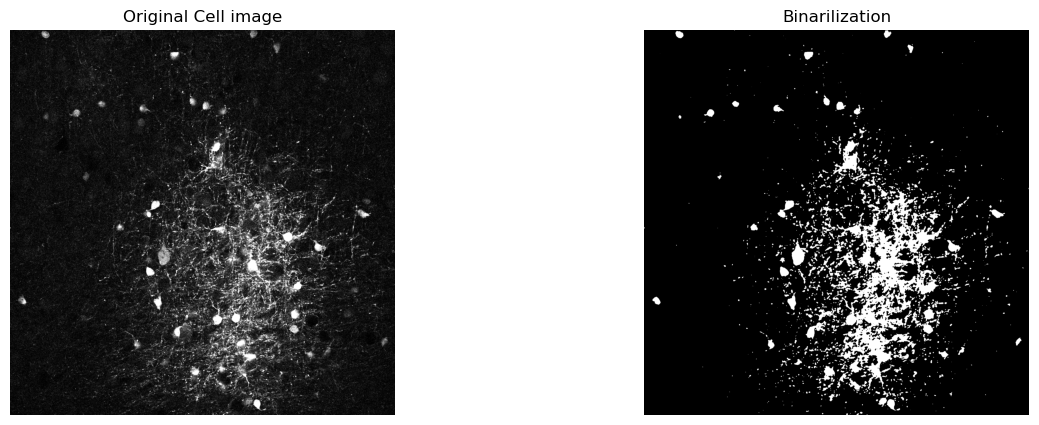

过滤后的细胞数量：137


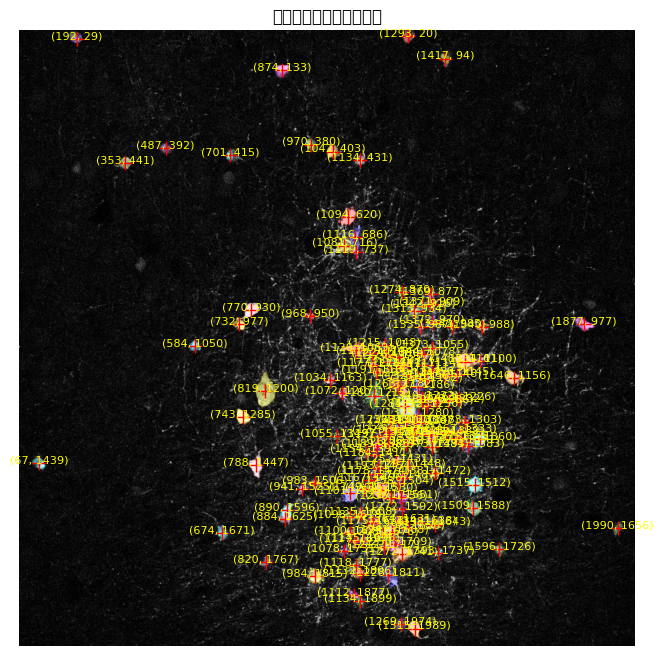

In [75]:
virus_binary, virus_positions, virus_pixel_coords = find(virus_channel)

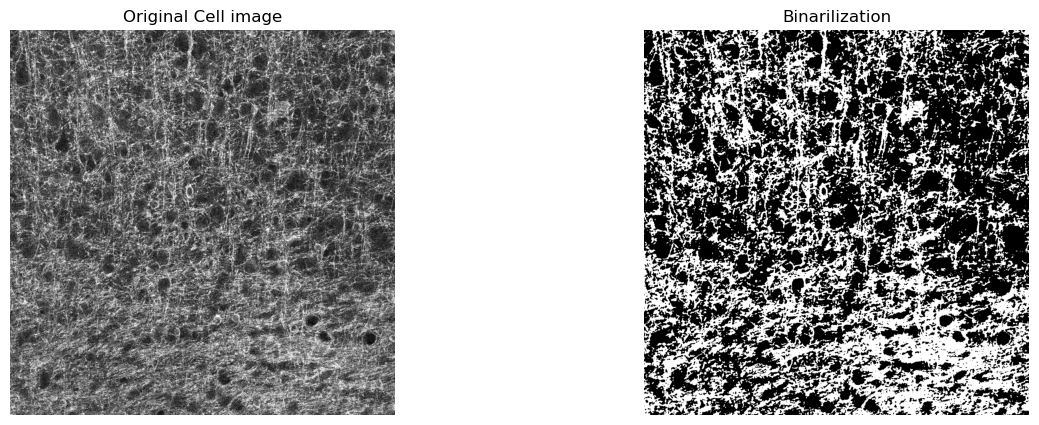

过滤后的细胞数量：691


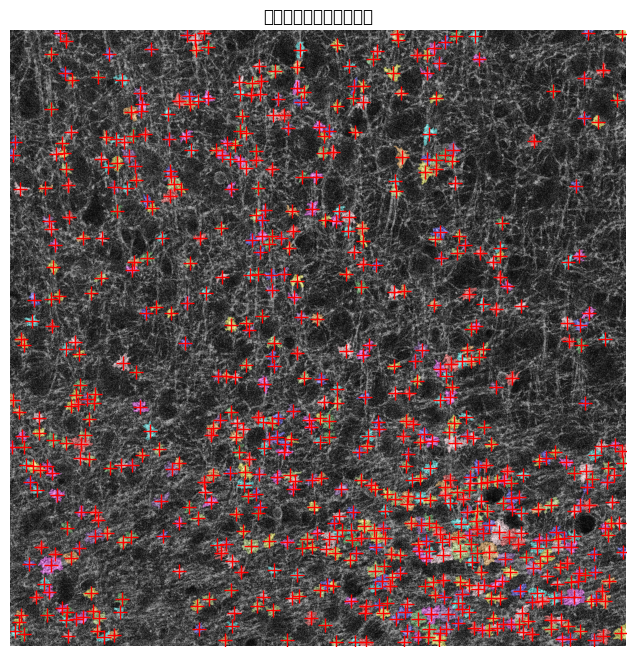

In [34]:
oligo_binary, oligo_positions, oligo_pixel_coords  = find(oligo_channel)

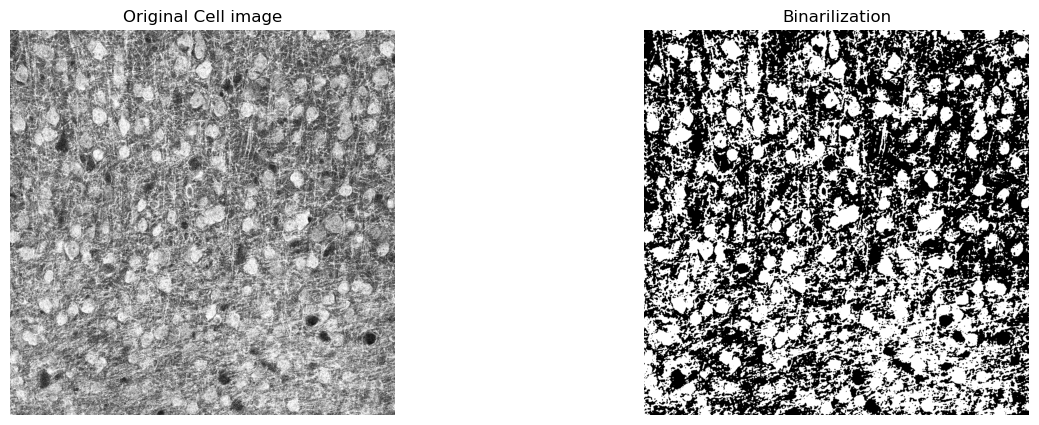

过滤后的细胞数量：777


d:\app\anaconda\envs\gen\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36807 (\N{CJK UNIFIED IDEOGRAPH-8FC7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\app\anaconda\envs\gen\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28388 (\N{CJK UNIFIED IDEOGRAPH-6EE4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\app\anaconda\envs\gen\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\app\anaconda\envs\gen\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\app\anaconda\envs\gen\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32454 (\N{CJK UNIFIED IDEOGRAPH-7EC6}) missing from current font.
  fig.canvas.print_figure(bytes_

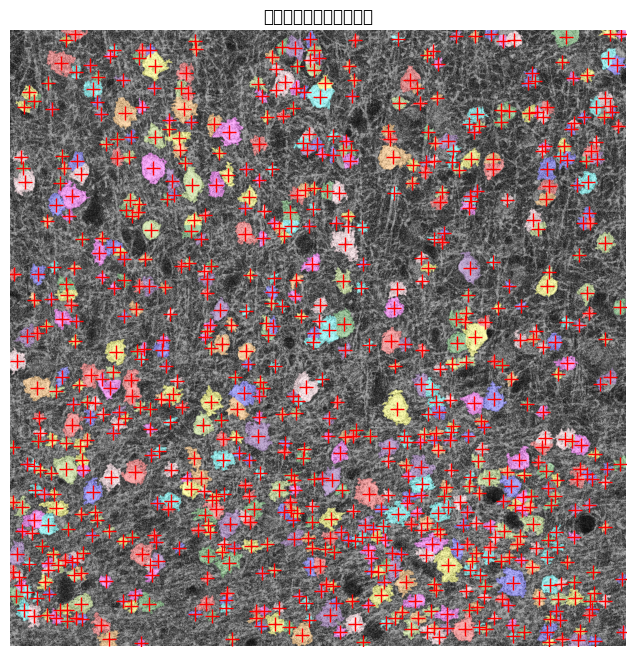

In [57]:
neuron_binary, neuron_positions, neuron_pixel_coords  = find(neuron_channel)

## 3 Cell Colocalization Analysis

In [ ]:
def crop_square_from_image(img, x, y, len):
    """
    Crops a square region from an image centered at a specified (x, y) coordinate.

    Parameters:
    img: ndarray
        The input image from which to crop.
    x: int
        The x-coordinate of the center of the square to be cropped.
    y: int
        The y-coordinate of the center of the square to be cropped.
    len: int
        Half the side length of the square to be cropped, meaning the total side 
        length of the cropped square will be 2 * len.

    Returns:
    ndarray:
        The cropped square region of the image.
    """
    cropped_img = img[y - len:y + len, x - len:x + len]
    return cropped_img


### Verify colocalization between virus and oligonucleotide markers.

In [105]:
virus_oligo_count = 0
virus_oligo_position = []

for y, x in virus_positions:
    x = int(x)
    y = int(y)
    # print(f'({x}, {y})')    
    
    binary_virus_sub = crop_square_from_image(virus_binary, x, y, len=20)
    binary_oligo_sub = crop_square_from_image(oligo_binary, x, y, len=20)
    binary_chB = binary_virus_sub & binary_oligo_sub

    # Calculate the Mander's coefficient for the two channels. Note the formula's above in the description. 
    M1 = np.sum(binary_chB)/np.sum(binary_virus_sub)
    M2 = np.sum(binary_chB)/np.sum(binary_oligo_sub)
    ratio_virus = np.sum(binary_virus_sub)/(binary_virus_sub.shape[0]**2)
    ratio_oligo = np.sum(binary_oligo_sub)/(binary_oligo_sub.shape[0]**2)

    # print(f"M1={M1}, M2={M2}", M1, M2)

    if (M1+M2>1.6 and ratio_virus>0.8 and ratio_oligo>0.8):
        virus_oligo_count += 1
        virus_oligo_position.append((x, y))

    # fig, ax = plt.subplots(2,2, figsize=(14, 14))

    # ax[0, 0].imshow(virus_binary, origin='upper')
    # ax[0, 0].set_title("virus_binary", fontsize=12)
    # rect = patches.Rectangle((x, y), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
    # ax[0, 0].add_patch(rect)

    # ax[0, 1].imshow(oligo_binary, origin='upper')
    # ax[0, 1].set_title("oligo_binary", fontsize=12)

    # ax[1, 0].imshow(binary_virus_sub, origin='upper')
    # ax[1, 0].set_title("binary_ch1", fontsize=12)
    # ax[1, 1].imshow(binary_oligo_sub, origin='upper')
    # ax[1, 1].set_title("binary_ch2", fontsize=12)

print(f'virus_oligo_count={virus_oligo_count}')

virus_oligo_count=18


### Verify colocalization between virus and neuron markers.

In [106]:
virus_neurons_count = 0
virus_neurons_position = []

for y, x in virus_positions:
    x = int(x)
    y = int(y)
    # print(f'({x}, {y})')    
    
    binary_virus_sub = crop_square_from_image(virus_binary, x, y, len=20)
    binary_neuron_sub = crop_square_from_image(neuron_binary, x, y, len=20)
    binary_chB = binary_virus_sub & binary_neuron_sub

    # Calculate the Mander's coefficient for the two channels. Note the formula's above in the description. 
    M1 = np.sum(binary_chB)/np.sum(binary_virus_sub)
    M2 = np.sum(binary_chB)/np.sum(binary_neuron_sub)
    ratio_virus = np.sum(binary_virus_sub)/(binary_virus_sub.shape[0]**2)
    ratio_neuron = np.sum(binary_neuron_sub)/(binary_neuron_sub.shape[0]**2)

    # print(f"M1={M1}, M2={M2}", M1, M2)

    if (M1+M2>1.6 and ratio_virus>0.8 and ratio_neuron>0.8):
        virus_neurons_count += 1
        virus_neurons_position.append((x, y))

    # fig, ax = plt.subplots(2,2, figsize=(14, 14))

    # ax[0, 0].imshow(virus_binary, origin='upper')
    # ax[0, 0].set_title("virus_binary", fontsize=12)
    # rect = patches.Rectangle((x, y), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
    # ax[0, 0].add_patch(rect)

    # ax[0, 1].imshow(neuron_binary, origin='upper')
    # ax[0, 1].set_title("neuron_binary", fontsize=12)

    # ax[1, 0].imshow(binary_virus_sub, origin='upper')
    # ax[1, 0].set_title("binary_ch1", fontsize=12)
    # ax[1, 1].imshow(binary_neuron_sub, origin='upper')
    # ax[1, 1].set_title("binary_ch2", fontsize=12)

print(f'virus_neurons_count={virus_neurons_count}')

virus_neurons_count=17


## Spatial Visualization of Colocalized Cells

<Figure size 640x480 with 0 Axes>

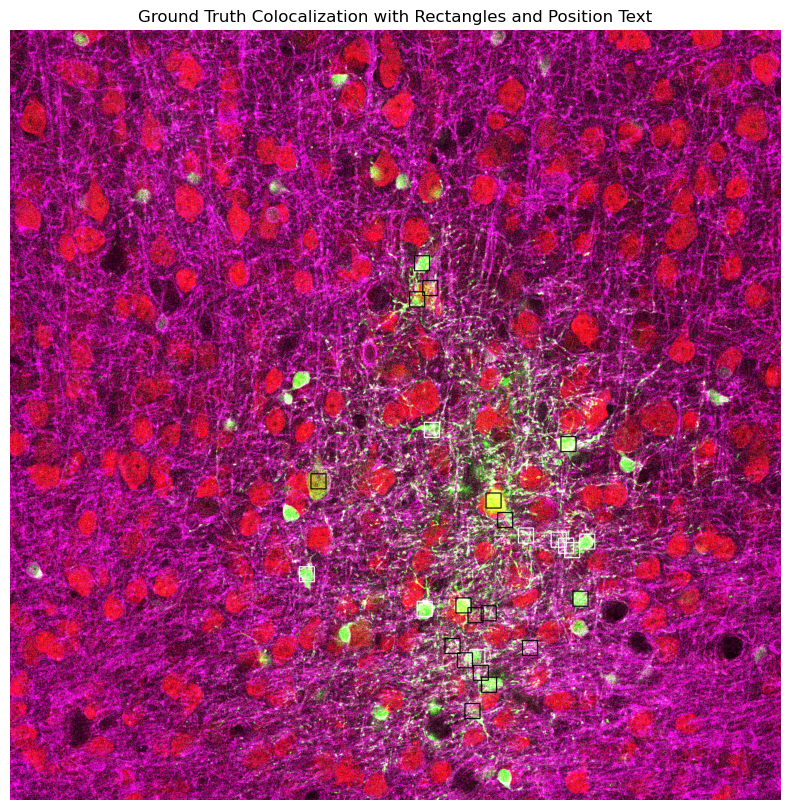

In [107]:
plt.clf()
image = cv2.imread(os.getcwd()+'/Image_Oligodendrocytes_virus_neurons.png')
box_size = 20
color_virus_oligo = (255, 255, 255)  # Blue for virus-oligo colocalization
color_virus_neuron = (0, 0, 0)  # Green for virus-neuron colocalization

for x, y in virus_oligo_position:
    top_left = (x - box_size, y - box_size)
    bottom_right = (x + box_size, y + box_size)
    cv2.rectangle(image, top_left, bottom_right, color_virus_oligo, 2)
    # cv2.putText(image, f'({x},{y})', (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_virus_neuron, 2)
    # print(f'[Oligo] (x, y) = {(x, y)}, virus_positive & oligo')

for x, y in virus_neurons_position:
    top_left = (x - box_size, y - box_size)
    bottom_right = (x + box_size, y + box_size)
    cv2.rectangle(image, top_left, bottom_right, color_virus_neuron, 2)
    # cv2.putText(image, f'({x},{y})', (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_virus_neuron, 2)
    # print(f'[Neuron] (x, y) = {(x, y)}, virus_positive & neuron')

plt.figure(figsize=(20, 10))
plt.imshow(image)
plt.title("Ground Truth Colocalization with Rectangles and Position Text")
plt.axis("off")  # Turn off axis for the second subplot
plt.show()

后面需要调参：